In [ ]:
# ===== 설정 =====
character_tag = "tezuka_saki"   # 이번 테스트 캐릭터
copyright_tag = "heaven_burns_red"  # 필요하면 유지, 원치 않으면 ""로

sleep_sec = 1.0
retries = 10

# 결과 저장 루트(Colab 로컬)
dataset_root = f"/content/danbooru_{character_tag}"

# --- 필터 설정 (general) ---
# - 표현식은 and/or/not, 괄호 지원
# - 예: "(1girl and solo) or 2girls"
general_include_expr = "(1girl and solo) or 2girls"

# include_expr이 비어 있을 때만 사용 (OR-of-AND)
# 예: [["1girl", "solo"], ["2girls"]]
general_include_groups = []

# 하나라도 포함되면 제외
general_exclude_tags = [
    "3girls",
    "4girls",
    "5girls",
    "6+girls",
    "4koma",
    "multiple_girls",
]

# --- 필터 설정 (copyright) ---
# 비워두면 필터 안 함
copyright_required = "heaven_burns_red"

# True면 해당 태그만 단독으로 있을 때만 통과
copyright_solo_only = True


In [2]:
# Google Drive 사용 안 함 (/content에 저장)


Mounted at /content/drive


In [3]:
!pip -q install -U gallery-dl
!gallery-dl --version


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 38.1 MB/s eta 0:00:00
1.31.2


In [4]:
!gallery-dl --help | grep -i -E "concurrent|jobs|thread|rate|sleep"

  -r, --limit-rate RATE       Maximum download rate (e.g. 500k, 2.5M, or
  --sleep SECONDS             Number of seconds to wait before each download.
  --sleep-skip SECONDS        Number of seconds to wait after skipping a file
  --sleep-request SECONDS     Number of seconds to wait between HTTP requests
  --sleep-429 SECONDS         Number of seconds to wait when receiving a '429
  --sleep-extractor SECONDS   Number of seconds to wait before starting data
  --write-metadata            Write metadata to separate JSON files
  --write-tags                Write image tags to separate text files


In [5]:
from urllib.parse import quote_plus

# Danbooru ??? general ??
# - and: ??
# - or : ~
# - not: -
general_query = "((1girl solo)~(2girls)) -3girls -4girls -5girls -6+girls -multiple_girls -4koma"

tags = [character_tag]
if copyright_tag:
    tags.append(copyright_tag)

tags.append(general_query)

tag_query = quote_plus(" ".join(tags))
url = f"https://danbooru.donmai.us/posts?tags={tag_query}"

print("URL:", url)


URL: https://danbooru.donmai.us/posts?tags=tezuka_saki+heaven_burns_red


In [6]:
import os

data_dir = os.path.join(dataset_root, "danbooru")
os.makedirs(data_dir, exist_ok=True)
print("data_dir:", data_dir)


data_dir: /content/drive/MyDrive/danbooru_tezuka_saki/danbooru


In [7]:
cmd = f'''gallery-dl \
  --directory "{data_dir}" \
  --filename "{{id}}_{{md5}}.{{extension}}" \
  --write-metadata \
  --retries {retries} \
  --sleep {sleep_sec} \
  "{url}"
'''
print(cmd)
!{cmd}


gallery-dl   --directory "/content/drive/MyDrive/danbooru_tezuka_saki/danbooru"   --filename "{id}_{md5}.{extension}"   --write-metadata   --retries 10   --sleep 1.0   "https://danbooru.donmai.us/posts?tags=tezuka_saki+heaven_burns_red"

/content/drive/MyDrive/danbooru_tezuka_…610_da627df88642192fbb70523a668feca1.jpg
/content/drive/MyDrive/danbooru_tezuka_…779_c485d71e7c65504889e180b57db56731.png
/content/drive/MyDrive/danbooru_tezuka_…143_08d26675a8b22326e47ef828d0861065.jpg
/content/drive/MyDrive/danbooru_tezuka_…188_1639c0a5f5b1502ead0d02502ceff56d.png
/content/drive/MyDrive/danbooru_tezuka_…369_e6ffa033b7422f73fbd48414c7de8725.jpg
/content/drive/MyDrive/danbooru_tezuka_…112_e8741892d72be96cd6ba5ee7ab5aa130.mp4
/content/drive/MyDrive/danbooru_tezuka_…543_277314752901a6bec02251f97a5be329.jpg
/content/drive/MyDrive/danbooru_tezuka_…136_fbe23a45f1cbc90325228a9a3ec23815.jpg
/content/drive/MyDrive/danbooru_tezuka_…985_1c8e3c6de5e86702f7c384f1578bc3c6.png
/content/drive/MyDrive/danbooru_t

In [ ]:
import os, glob, json
from pathlib import Path

# 이미지 전용 확장자
IMAGE_EXTS = (".jpg", ".jpeg", ".png", ".webp", ".gif")
img_exts = IMAGE_EXTS

# --- 필터 설정 정규화 ---
GENERAL_INCLUDE_EXPR = (general_include_expr or "").strip()
GENERAL_EXCLUDE_TAGS = {str(t).lower() for t in (general_exclude_tags or []) if t}

GENERAL_INCLUDE_GROUPS = []
for group in (general_include_groups or []):
    if group:
        GENERAL_INCLUDE_GROUPS.append({str(t).lower() for t in group if t})

COPYRIGHT_REQUIRED = (copyright_required or "").strip().lower()
COPYRIGHT_SOLO_ONLY = bool(copyright_solo_only)


def split_tags(s: str):
    return {t.lower() for t in (s or "").split()}


def is_image_path(path: str) -> bool:
    return Path(path).suffix.lower() in IMAGE_EXTS


def key_from_json(jp: str) -> str:
    return jp[:-5]  # ".json" 제거


def key_from_caption(cp: str) -> str:
    return cp[:-len(".caption.txt")]


def is_image_json(jp: str) -> bool:
    return is_image_path(key_from_json(jp))


def tokenize_expr(expr: str):
    tokens = []
    i = 0
    while i < len(expr):
        ch = expr[i]
        if ch.isspace():
            i += 1
            continue
        if ch in "()":
            tokens.append(ch)
            i += 1
            continue
        j = i
        while j < len(expr) and (not expr[j].isspace()) and (expr[j] not in "()"):
            j += 1
        tokens.append(expr[i:j])
        i = j
    return tokens


def to_rpn(tokens):
    prec = {"or": 1, "and": 2, "not": 3}
    out = []
    stack = []
    for tok in tokens:
        t = tok.lower()
        if t in prec:
            while stack and stack[-1] != "(" and prec.get(stack[-1], 0) >= prec[t]:
                out.append(stack.pop())
            stack.append(t)
        elif tok == "(":
            stack.append(tok)
        elif tok == ")":
            while stack and stack[-1] != "(":
                out.append(stack.pop())
            if not stack:
                raise ValueError("괄호가 맞지 않습니다.")
            stack.pop()
        else:
            out.append(tok)
    while stack:
        if stack[-1] == "(":
            raise ValueError("괄호가 맞지 않습니다.")
        out.append(stack.pop())
    return out


def compile_expr(expr: str):
    tokens = tokenize_expr(expr)
    if not tokens:
        return []
    return to_rpn(tokens)


def eval_rpn(rpn, tags: set):
    stack = []
    for tok in rpn:
        t = tok.lower()
        if t == "and":
            if len(stack) < 2:
                raise ValueError("AND 연산 항목이 부족합니다.")
            b = stack.pop()
            a = stack.pop()
            stack.append(a and b)
        elif t == "or":
            if len(stack) < 2:
                raise ValueError("OR 연산 항목이 부족합니다.")
            b = stack.pop()
            a = stack.pop()
            stack.append(a or b)
        elif t == "not":
            if not stack:
                raise ValueError("NOT 연산 항목이 부족합니다.")
            a = stack.pop()
            stack.append(not a)
        else:
            stack.append(t in tags)
    if len(stack) != 1:
        raise ValueError("태그 표현식을 평가할 수 없습니다.")
    return stack[0]


GENERAL_INCLUDE_RPN = compile_expr(GENERAL_INCLUDE_EXPR) if GENERAL_INCLUDE_EXPR else []


def match_general(tags: set) -> bool:
    if GENERAL_EXCLUDE_TAGS & tags:
        return False
    if GENERAL_INCLUDE_RPN:
        return eval_rpn(GENERAL_INCLUDE_RPN, tags)
    if GENERAL_INCLUDE_GROUPS:
        for group in GENERAL_INCLUDE_GROUPS:
            if group.issubset(tags):
                return True
        return False
    return True


def match_copyright(meta: dict) -> bool:
    if not COPYRIGHT_REQUIRED:
        return True
    tags = split_tags(meta.get("tag_string_copyright"))
    if COPYRIGHT_SOLO_ONLY:
        return tags == {COPYRIGHT_REQUIRED}
    return COPYRIGHT_REQUIRED in tags


def is_allowed(meta: dict) -> bool:
    general_tags = split_tags(meta.get("tag_string_general"))
    return match_general(general_tags) and match_copyright(meta)


images: 91
json  : 92
sample image: 10552610_da627df88642192fbb70523a668feca1.jpg
sample json : 10552610_da627df88642192fbb70523a668feca1.jpg.json


In [ ]:
json_files = glob.glob(os.path.join(data_dir, "*.json"))
img_json_files = [jp for jp in json_files if is_image_json(jp)]
print("json files (image):", len(img_json_files))

skipped_non_image = len(json_files) - len(img_json_files)
if skipped_non_image:
    print("skipped non-image json:", skipped_non_image)


def make_caption(meta):
    parts = []
    for key in ["tag_string_artist", "tag_string_copyright", "tag_string_character", "tag_string_general"]:
        v = (meta.get(key) or "").strip()
        if v:
            parts.append(v)
    return " ".join(parts).strip()


empty = 0
kept = 0
skipped_rule = 0

for jp in img_json_files:
    with open(jp, "r", encoding="utf-8") as f:
        meta = json.load(f)

    if not is_allowed(meta):
        skipped_rule += 1
        continue

    caption = make_caption(meta)

    img_path = key_from_json(jp)
    cap_path = img_path + ".caption.txt"

    with open(cap_path, "w", encoding="utf-8") as f:
        f.write(caption + "\n")

    if not caption:
        empty += 1

    kept += 1

print("filtered by rules:", skipped_rule)
print("captions made:", kept)
print("empty captions:", empty)


json files: 92
captions made: 92
empty captions: 0


In [ ]:
# --- 1) JSON 필터링 ---
json_files = glob.glob(os.path.join(data_dir, "*.json"))
json_files = [jp for jp in json_files if is_image_json(jp)]

allowed_json_files = []
skipped_rule = 0

for jp in json_files:
    with open(jp, "r", encoding="utf-8") as f:
        meta = json.load(f)

    if not is_allowed(meta):
        skipped_rule += 1
        continue

    allowed_json_files.append(jp)

# --- 2) 기대 경로 생성 ---
img_paths = [key_from_json(jp) for jp in allowed_json_files]
cap_paths = [p + ".caption.txt" for p in img_paths]

missing_img = sorted([p for p in img_paths if not os.path.exists(p)])
missing_cap = sorted([p for p in cap_paths if not os.path.exists(p)])

print("json (image):", len(json_files))
print("filtered by rules:", skipped_rule)
print("images (expected):", len(img_paths))
print("caps (expected):", len(cap_paths))
print()
print("missing image:", len(missing_img))
print("missing caption:", len(missing_cap))
print("\nSample missing image:", missing_img[:3])
print("Sample missing cap:", missing_cap[:3])

# --- 3) 인덱스(jsonl) 생성 ---
out_path = os.path.join(dataset_root, "dataset_index_fixed.jsonl")

missing_img_idx = 0
missing_cap_idx = 0

with open(out_path, "w", encoding="utf-8") as out:
    for jp in allowed_json_files:
        with open(jp, "r", encoding="utf-8") as f:
            meta = json.load(f)

        img_path = key_from_json(jp)
        cap_path = img_path + ".caption.txt"

        if not os.path.exists(img_path):
            missing_img_idx += 1
            continue
        if not os.path.exists(cap_path):
            missing_cap_idx += 1
            continue

        rec = {
            "post_id": meta.get("id"),
            "image_path": img_path,
            "json_path": jp,
            "caption_path": cap_path,

            "artist": (meta.get("tag_string_artist") or "").split(),
            "copyright": (meta.get("tag_string_copyright") or "").split(),
            "character": (meta.get("tag_string_character") or "").split(),
            "general": (meta.get("tag_string_general") or "").split(),
        }
        out.write(json.dumps(rec, ensure_ascii=False) + "\n")

print("\nrecords:", len(allowed_json_files))
print("missing image:", missing_img_idx)
print("missing caption:", missing_cap_idx)
print("saved:", out_path)


images: 91 unique stems: 91
json  : 92 unique stems: 92
caps  : 92 unique stems: 92

images missing json: 91
images missing cap : 91
orphan json(no image): 92
orphan cap (no image): 92

Sample missing cap: ['/content/drive/MyDrive/danbooru_tezuka_saki/danbooru/10053514_c711ca5a96f9f7fcd04431cbb05a4903', '/content/drive/MyDrive/danbooru_tezuka_saki/danbooru/10067474_f31a5f94354211696e5723b44925cb60', '/content/drive/MyDrive/danbooru_tezuka_saki/danbooru/10069803_507ec50c2f28835a5b17b7e51a6bae41']
Sample orphan json: ['/content/drive/MyDrive/danbooru_tezuka_saki/danbooru/10053514_c711ca5a96f9f7fcd04431cbb05a4903.jpg', '/content/drive/MyDrive/danbooru_tezuka_saki/danbooru/10067474_f31a5f94354211696e5723b44925cb60.jpg', '/content/drive/MyDrive/danbooru_tezuka_saki/danbooru/10069803_507ec50c2f28835a5b17b7e51a6bae41.jpg']


### ✅ Sample

- **image**: `/content/drive/MyDrive/danbooru_tezuka_saki/danbooru/8956021_74eed81e590d96c5db3c94ef41a6f661.jpg`

- **json**: `/content/drive/MyDrive/danbooru_tezuka_saki/danbooru/8956021_74eed81e590d96c5db3c94ef41a6f661.jpg.json`

- **caption**: `/content/drive/MyDrive/danbooru_tezuka_saki/danbooru/8956021_74eed81e590d96c5db3c94ef41a6f661.jpg.caption.txt`

- **danbooru id**: `8956021`

- **danbooru link**: https://danbooru.donmai.us/posts/8956021

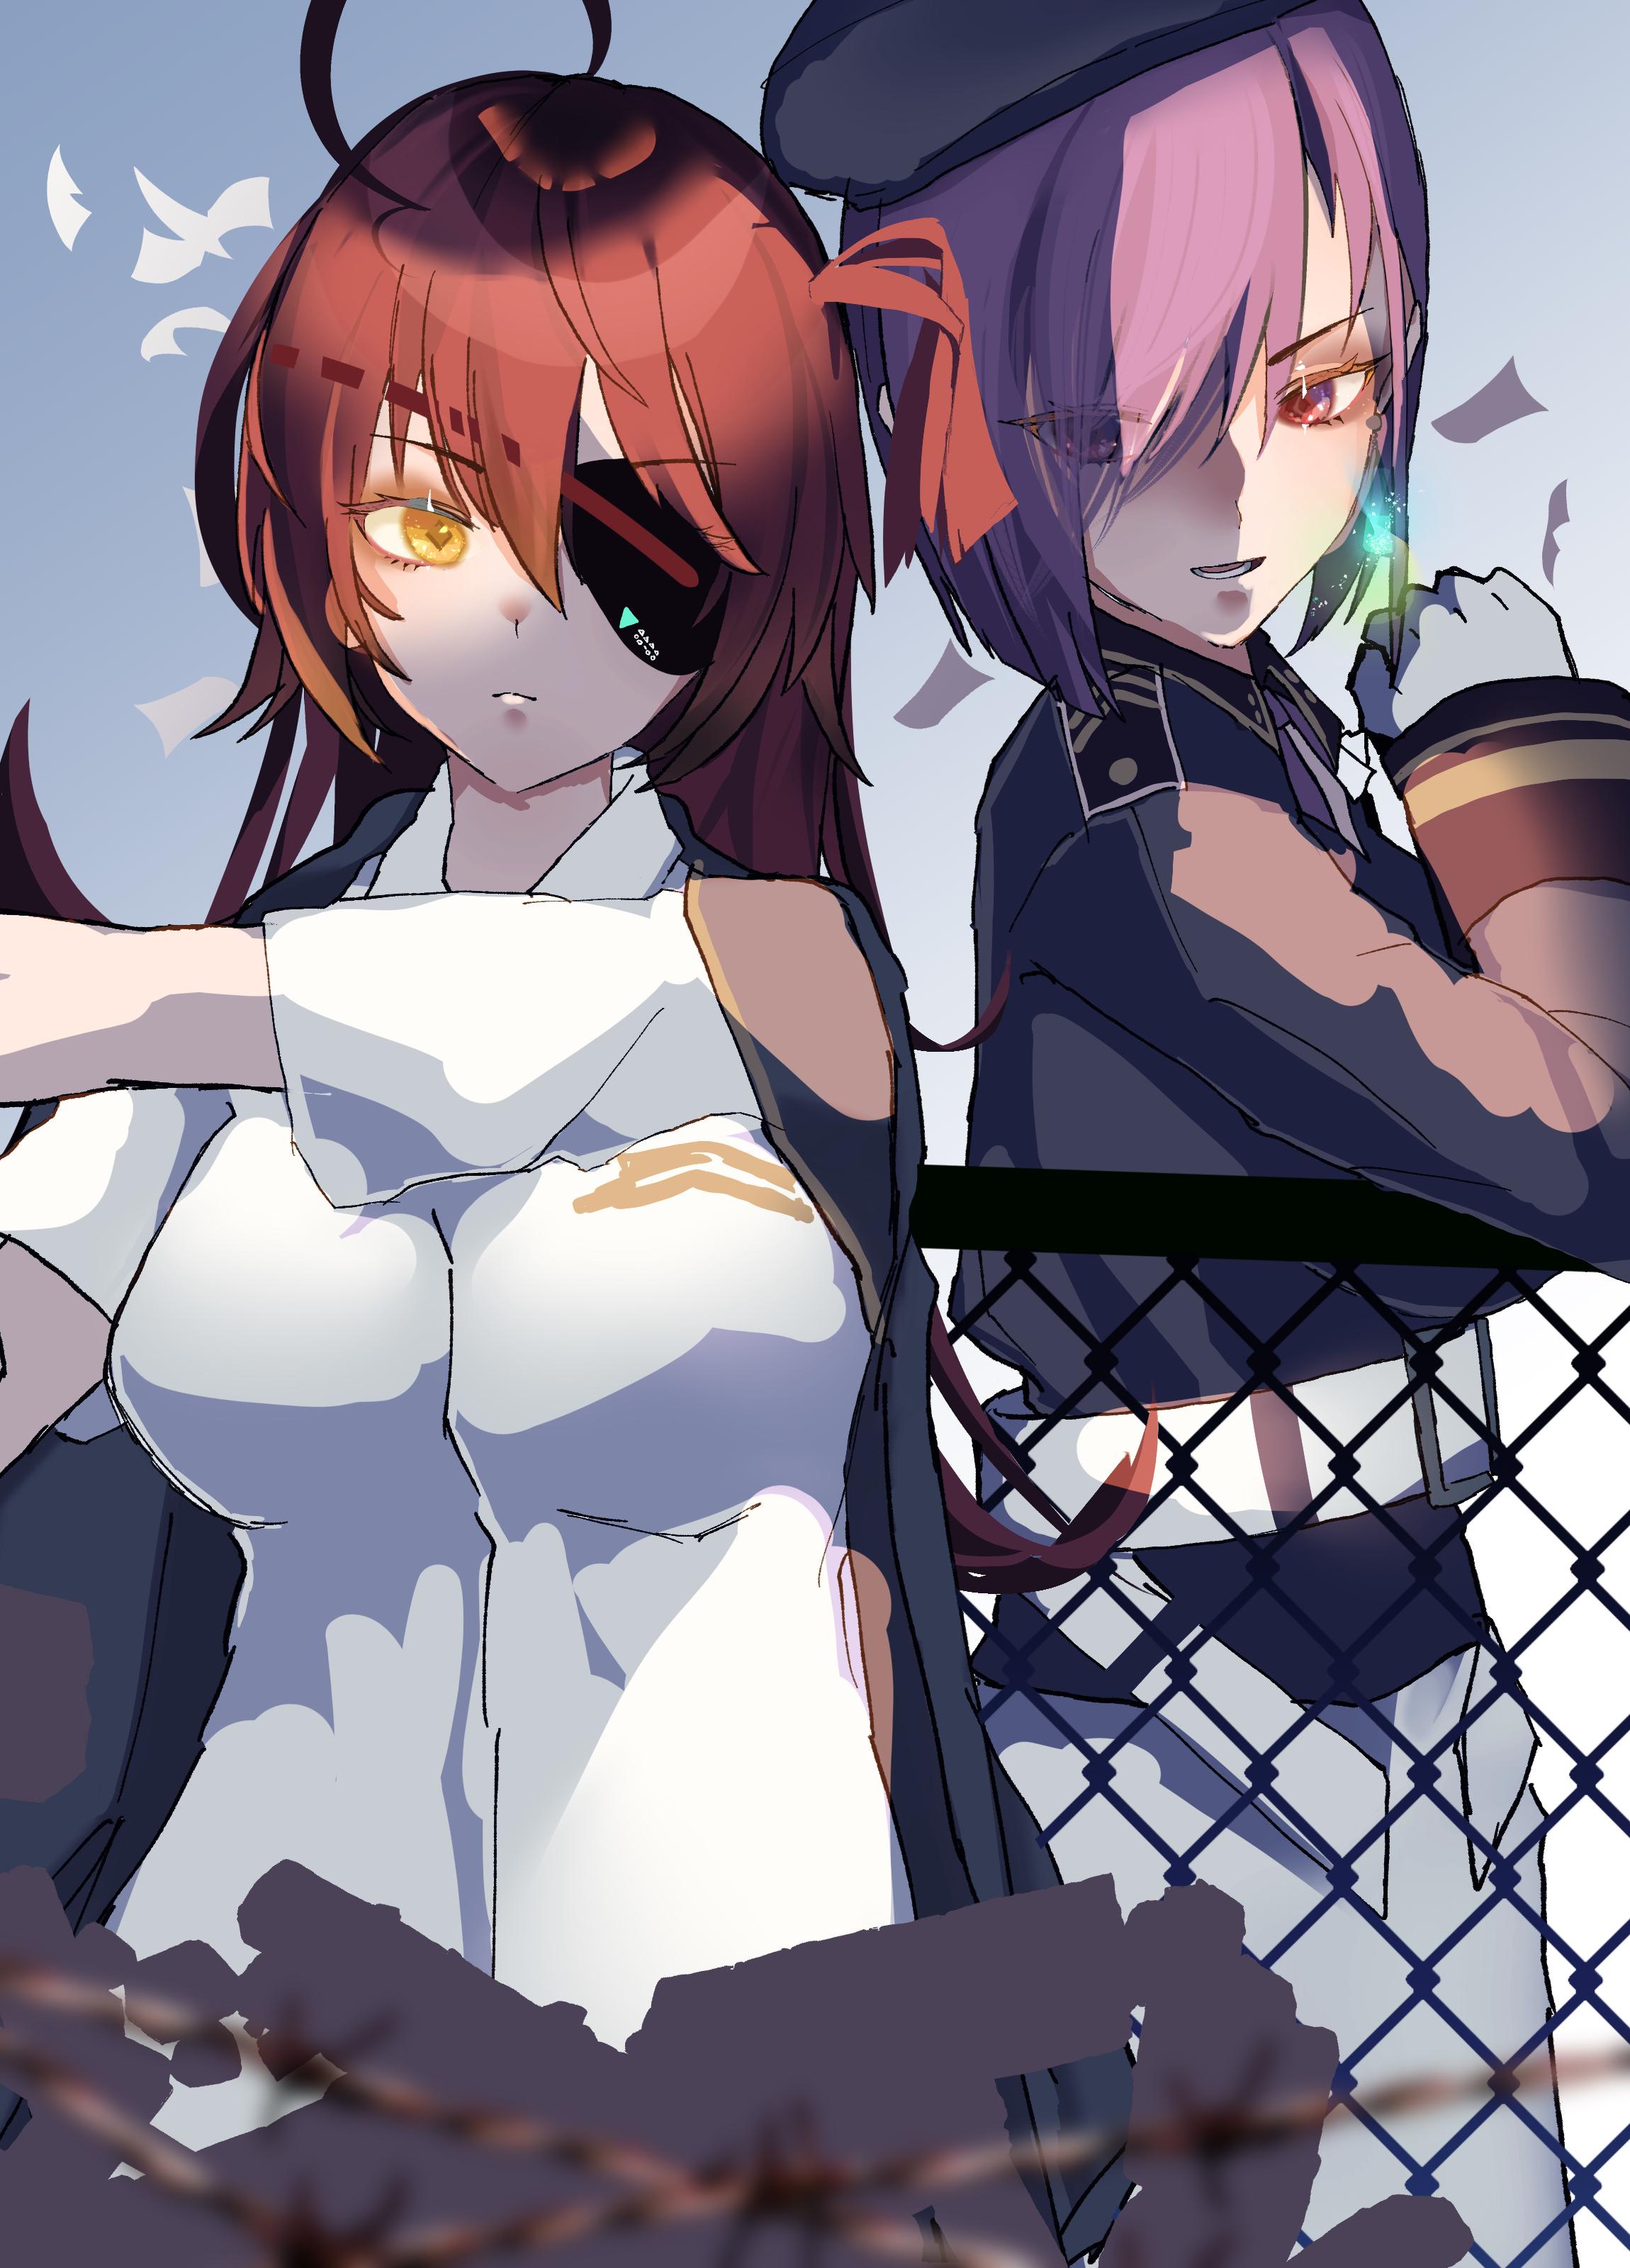

**Tags (by category)**

- artist: `108shizuku`

- copyright: `heaven_burns_red`

- character: `asami_makiko_(heaven_burns_red) tezuka_saki`

- general (head): `2girls ahoge breasts collared_shirt earrings eyepatch jacket jacket_on_shoulders jewelry large_breasts long_hair multiple_girls purple_hair red_eyes red_hair shirt short_hair single_earring white_shir...`

**Caption file content (head)**

`108shizuku heaven_burns_red asami_makiko_(heaven_burns_red) tezuka_saki 2girls ahoge breasts collared_shirt earrings eyepatch jacket jacket_on_shoulders jewelry large_breasts long_hair multiple_girls purple_hair red_eyes red_hair shirt short_hair single_earring white_shirt yellow_eyes`

### ✅ Sample

- **image**: `/content/drive/MyDrive/danbooru_tezuka_saki/danbooru/8423559_98ee6a74b4f5f4960c91d55ffc12f73b.jpg`

- **json**: `/content/drive/MyDrive/danbooru_tezuka_saki/danbooru/8423559_98ee6a74b4f5f4960c91d55ffc12f73b.jpg.json`

- **caption**: `/content/drive/MyDrive/danbooru_tezuka_saki/danbooru/8423559_98ee6a74b4f5f4960c91d55ffc12f73b.jpg.caption.txt`

- **danbooru id**: `8423559`

- **danbooru link**: https://danbooru.donmai.us/posts/8423559

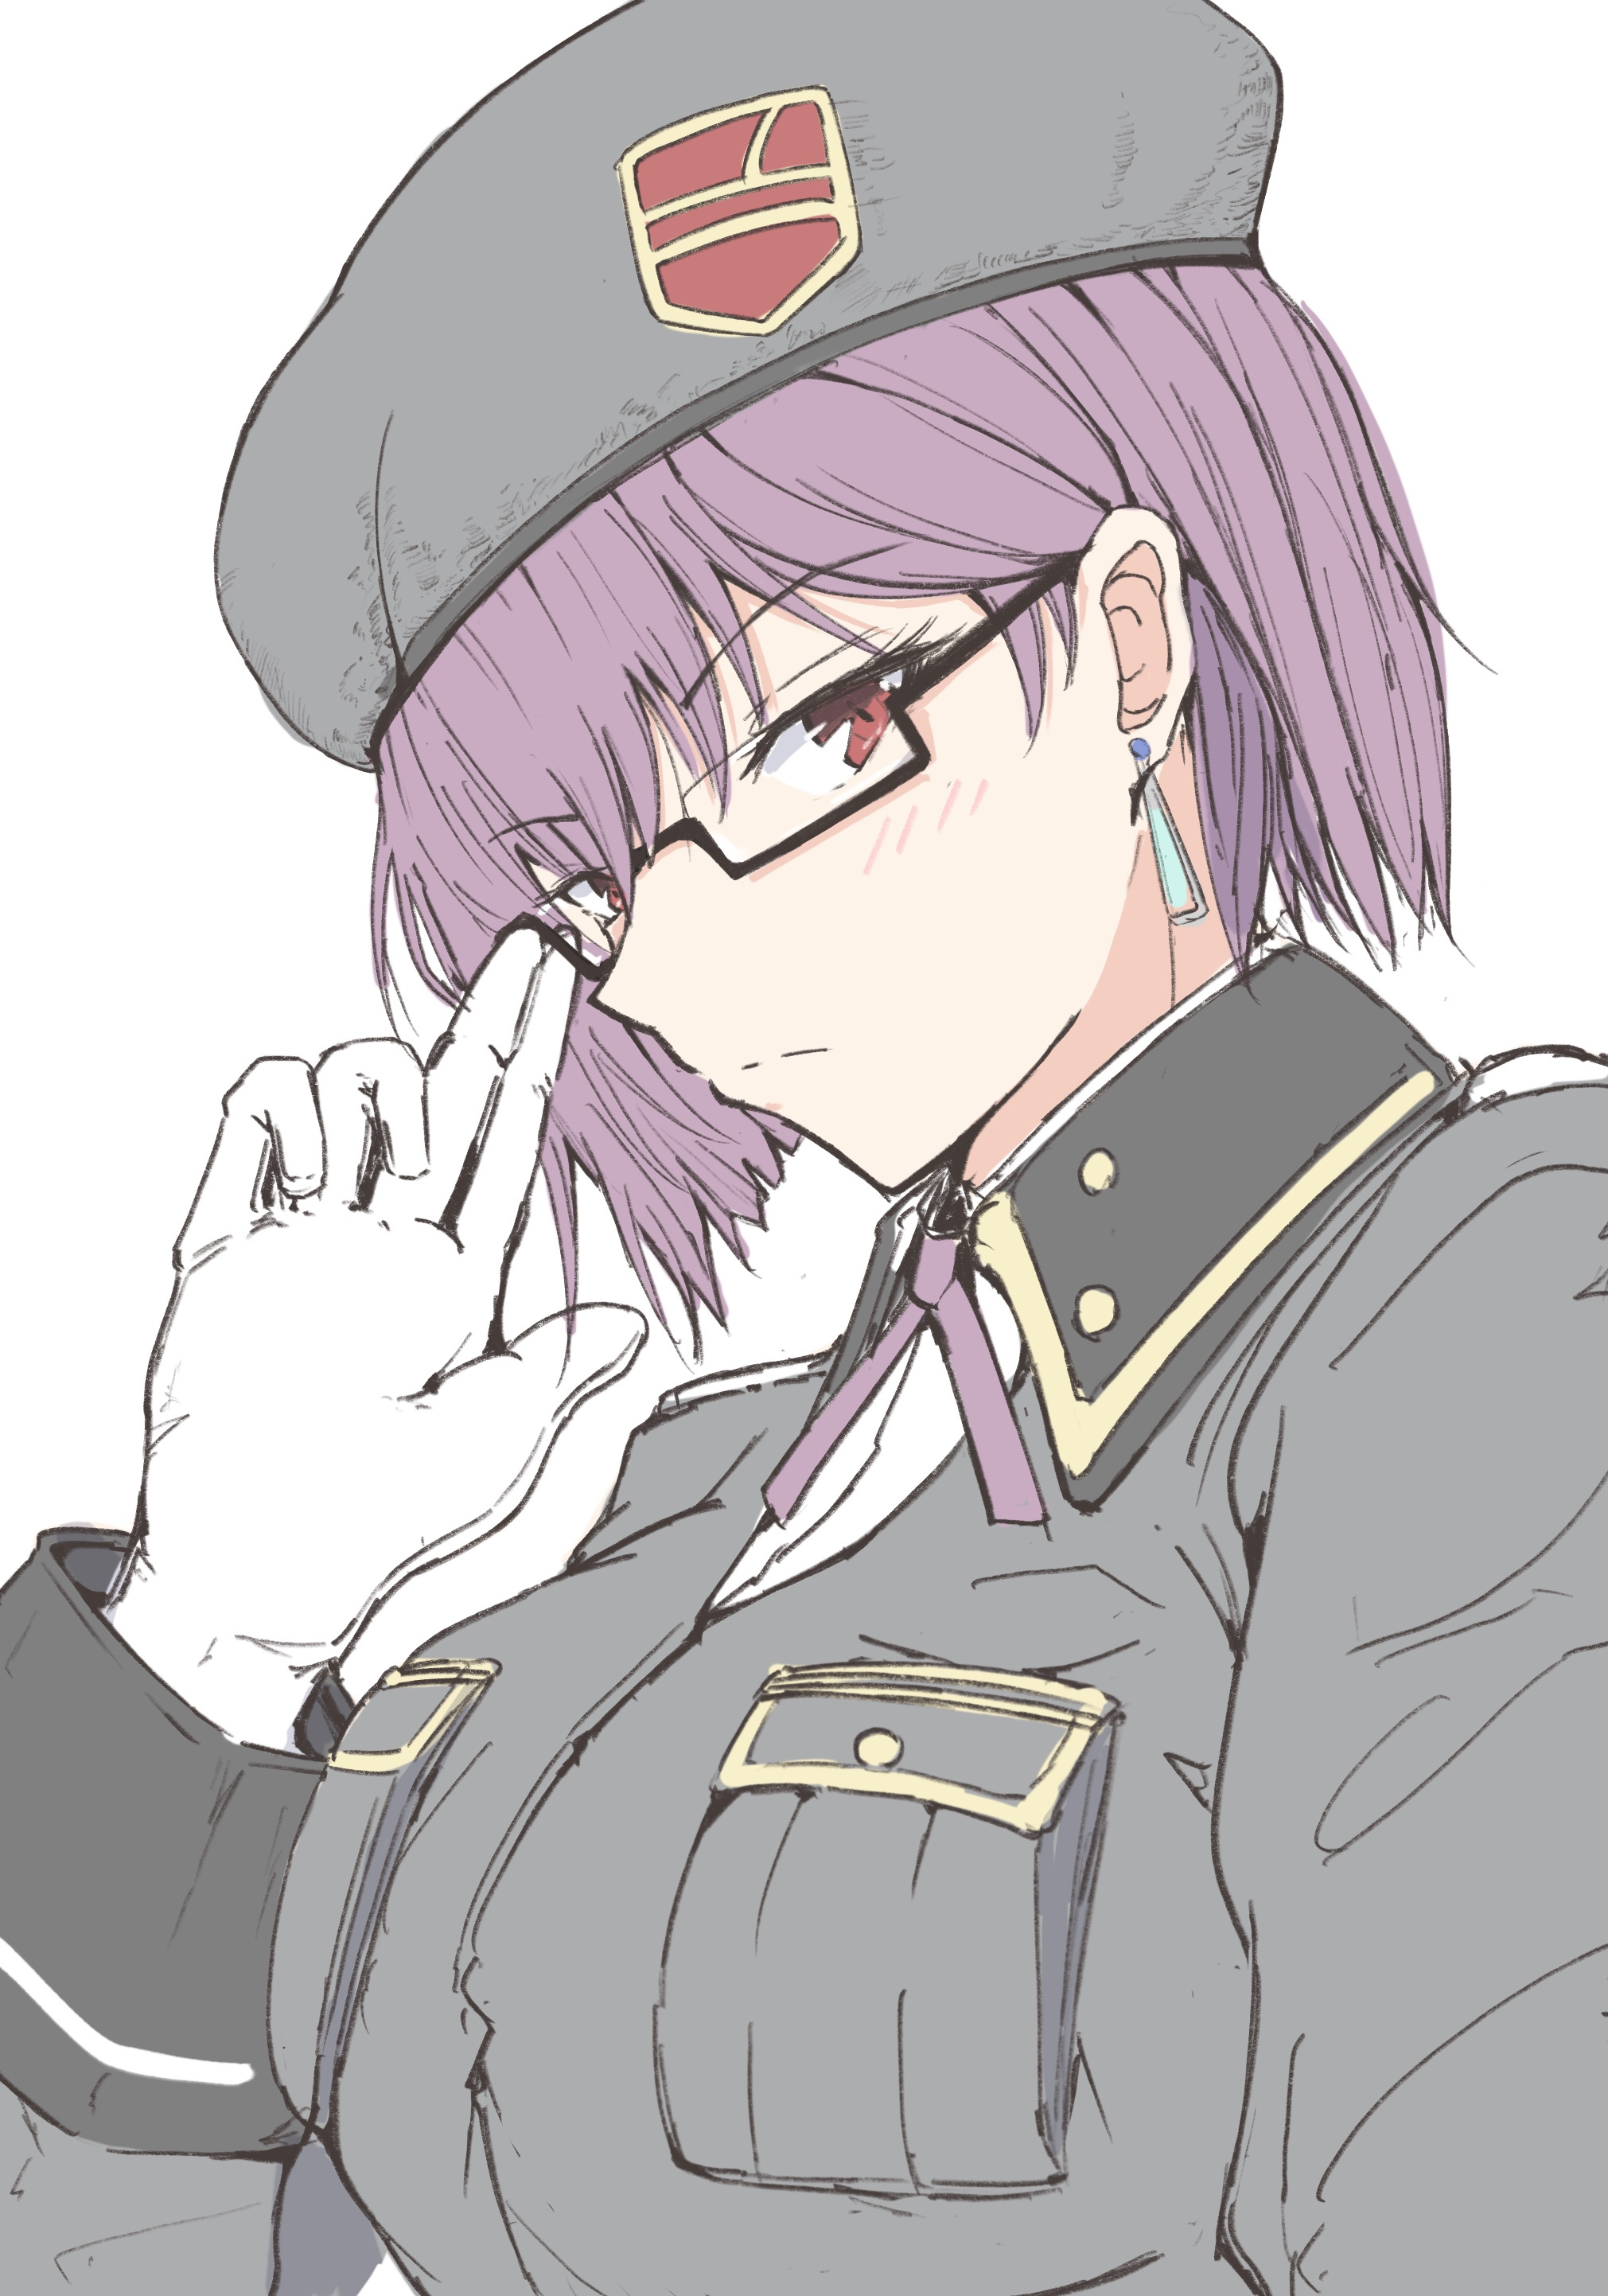

**Tags (by category)**

- artist: `potenara`

- copyright: `heaven_burns_red`

- character: `tezuka_saki`

- general (head): `1girl adjusting_eyewear black_jacket breasts collared_shirt earrings glasses hat jacket jewelry large_breasts military_hat purple_hair red_eyes shirt short_hair single_earring solo`

**Caption file content (head)**

`potenara heaven_burns_red tezuka_saki 1girl adjusting_eyewear black_jacket breasts collared_shirt earrings glasses hat jacket jewelry large_breasts military_hat purple_hair red_eyes shirt short_hair single_earring solo`

In [12]:
import random, json, os, glob
from IPython.display import display, Image, Markdown

img_files = []
for e in img_exts:
    img_files += glob.glob(os.path.join(data_dir, f"*{e}"))

samples = random.sample(img_files, k=min(2, len(img_files)))


def find_json(img_path):
    return img_path + ".json"


def show_one(img_path):
    jp = find_json(img_path)
    with open(jp, "r", encoding="utf-8") as f:
        meta = json.load(f)

    post_id = meta.get("id")
    link = f"https://danbooru.donmai.us/posts/{post_id}"

    cap_path = img_path + ".caption.txt"
    caption_text = open(cap_path, encoding="utf-8").read().strip() if os.path.exists(cap_path) else ""

    display(Markdown("### Sample"))
    display(Markdown(f"- **image**: `{img_path}`"))
    display(Markdown(f"- **json**: `{jp}`"))
    display(Markdown(f"- **caption**: `{cap_path}`"))
    display(Markdown(f"- **danbooru id**: `{post_id}`"))
    display(Markdown(f"- **danbooru link**: {link}"))
    display(Image(filename=img_path))

    display(Markdown("**Tags (by category)**"))
    display(Markdown(f"- artist: `{meta.get('tag_string_artist','')}`"))
    display(Markdown(f"- copyright: `{meta.get('tag_string_copyright','')}`"))
    display(Markdown(f"- character: `{meta.get('tag_string_character','')}`"))
    g = meta.get("tag_string_general","")
    display(Markdown(f"- general (head): `{g[:200]}{'...' if len(g)>200 else ''}`"))

    display(Markdown("**Caption file content (head)**"))
    display(Markdown(f"`{caption_text[:300]}{'...' if len(caption_text)>300 else ''}`"))


for p in samples:
    show_one(p)
